# Notebook 3: Advanced Model - LSTM Autoencoder

### Objective
The goal of this notebook is to develop a more sophisticated anomaly detection model using a deep learning approach. We will build an **LSTM (Long Short-Term Memory) Autoencoder** to learn the temporal patterns in our time-series data and identify anomalies as deviations from these learned patterns.

### Why an LSTM Autoencoder?
-   **LSTMs** are excellent for sequential data as they can capture long-term dependencies.

This approach is powerful for detecting more subtle, **contextual anomalies** that a simpler model like `IsolationForest` might miss.

### Key Steps
1.  **Setup & Data Loading**: Import libraries and load the prepared dataset.
2.  **Data Preprocessing for LSTMs**: Scale the data and transform it into sequences (or "windows").
3.  **Model Architecture**: Build the LSTM Autoencoder model using TensorFlow/Keras.
4.  **Model Training**: Train the autoencoder exclusively on normal data sequences.
5.  **Evaluation**: Determine an anomaly threshold based on reconstruction error and evaluate the model's performance.
6.  **Comparison**: Compare the results against our `IsolationForest` baseline.

### Expected Outcome
A trained LSTM Autoencoder model capable of detecting anomalies in time-series data, and a comparative analysis of its performance against the baseline model.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
import json
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 6)
tf.random.set_seed(7)
np.random.seed(7)

# --- Path Configuration ---
BASE_DIR = ".."
DATA_ROOT_DIR = os.path.join(BASE_DIR, "data/raw/NAB-master")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODELS_DIR = os.path.join(BASE_DIR, "models")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# --- Dataset Selection ---
DATASET_NAME = "realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"
LABELS_FILE = "labels/combined_labels.json"

data_path = os.path.join(DATA_ROOT_DIR, "data", DATASET_NAME)
label_path = os.path.join(DATA_ROOT_DIR, LABELS_FILE)

print("Configuration complete")

Configuration complete


## Data Loading and Preparation

In [2]:
df = pd.read_csv(data_path, parse_dates=['timestamp'], index_col='timestamp')

with open(label_path, 'r') as f:
    labels = json.load(f)

# Integrate labels into the DataFrame
anomaly_timestamp_strings = labels.get(DATASET_NAME, [])
anomaly_datetimes = pd.to_datetime(anomaly_timestamp_strings)
df['is_anomaly'] = 0
anomalies_in_df_index = df.index.intersection(anomaly_datetimes)
df.loc[anomalies_in_df_index, 'is_anomaly'] = 1

print("Data loaded and prepared.")
display(df.head())

Data loaded and prepared.


,value,is_anomaly
timestamp,,
2014-02-14 14:30:00,0.132,0
2014-02-14 14:35:00,0.134,0
2014-02-14 14:40:00,0.134,0
2014-02-14 14:45:00,0.134,0
2014-02-14 14:50:00,0.134,0


## Data Preprocessing for LSTMs

Neural networks are sensitive to the scale of input data. We will scale our `value` column to a range between 0 and 1 using `MinMaxScaler`.

In [3]:
scaler_fit_df = df[df['is_anomaly'] == 0]

scaler = MinMaxScaler()
scaler = scaler.fit(scaler_fit_df[['value']])

df['value_scaled'] = scaler.transform(df[['value']])

print("Data has been scaled.")
display(df.head())

Data has been scaled.


,value,is_anomaly,value_scaled
timestamp,,,
2014-02-14 14:30:00,0.132,0,0.043025
2014-02-14 14:35:00,0.134,0,0.044329
2014-02-14 14:40:00,0.134,0,0.044329
2014-02-14 14:45:00,0.134,0,0.044329
2014-02-14 14:50:00,0.134,0,0.044329


### Creating Temporal Sequences

LSTMs require input data to be in the form of sequences. We can't just feed the model one data point at a time; we need to provide a sequence of historical points. 

We will create a helper function to transform our flat time-series data into overlapping sequences. For our autoencoder, the input and the output of the model will be the same sequence. The model's job is to learn how to reconstruct this sequence of normal data.

In [4]:
train_df = df[df['is_anomaly'] == 0]


TIME_STEPS = 30

def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
    return np.array(sequences)


X_train = create_sequences(train_df['value_scaled'].values, TIME_STEPS)

print("\nSequence creation complete.")
print(f"Shape of training sequences: {X_train.shape}")

# Reshape the data to the 3D format expected by LSTMs [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Shape of training sequences after reshape: {X_train.shape}")


Sequence creation complete.
Shape of training sequences: (4000, 30)
Shape of training sequences after reshape: (4000, 30, 1)


## Building the LSTM Autoencoder

Now we will define the architecture of our LSTM Autoencoder. The model will consist of two main components:

1.  **Encoder**: This part of the network learns to compress the input sequence into a lower-dimensional latent representation (a dense vector). It consists of LSTM layers that process the input sequence.
2.  **Decoder**: This part of the network learns to reconstruct the original sequence from the latent representation. It uses a `RepeatVector` layer to duplicate the latent vector, feeding it into another set of LSTM layers to generate the output sequence.

The `TimeDistributed(Dense)` layer is used as the final output layer to ensure that we get one output for each time step in the input sequence. The model is compiled with the `adam` optimizer and `mae` (mean absolute error) as the loss function, as we are interested in minimizing the reconstruction error.

In [5]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Encoder
# The LSTM layer will learn the temporal patterns and compress the sequence.
# 16 is the dimensionality of the latent space.
encoder = LSTM(16, activation='relu', return_sequences=False)(inputs)

# Decoder
# RepeatVector repeats the learned latent vector for each time step,
# so we can feed it back into another LSTM layer.
decoder = RepeatVector(X_train.shape[1])(encoder)
decoder = LSTM(16, activation='relu', return_sequences=True)(decoder)

# The output layer applies a Dense layer to each time step of the sequence.
output = TimeDistributed(Dense(X_train.shape[2]))(decoder)

model = Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1)          │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

Now we will train our autoencoder. We will fit the model using our `X_train` data as both the input and the target. This is because an autoencoder's goal is to learn how to reconstruct its own input.

A `validation_split` is used to monitor the model's performance on a subset of the training data it hasn't been trained on in the current epoch. This helps us check for overfitting.

In [6]:
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ]
)

print("\nModel training complete")

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0178 - val_loss: 0.0158
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0152 - val_loss: 0.0153
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0153 - val_loss: 0.0152
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 

## Visualizing Training History

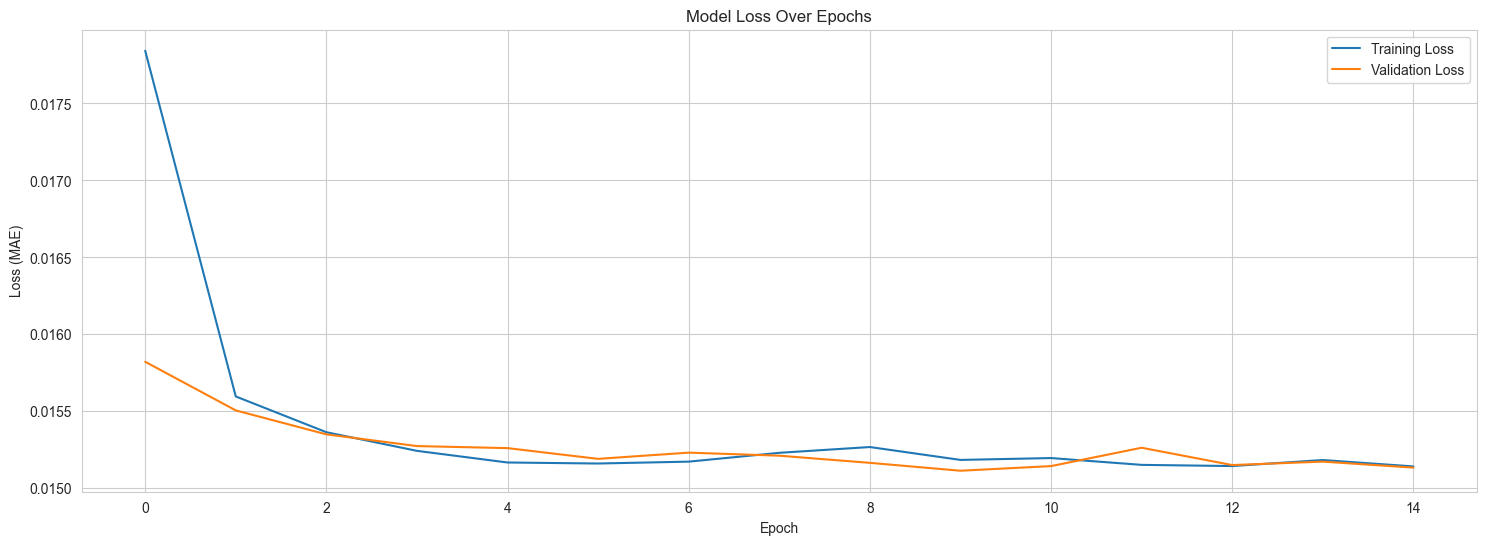

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation and Anomaly Thresholding

With a trained model, we can now determine a threshold for identifying anomalies. The process is as follows:

1.  **Calculate Reconstruction Error**: We will get the model's predictions on our **normal training data**. The difference between the original data and the model's reconstruction is the **reconstruction error** (we'll use Mean Absolute Error - MAE).
2.  **Determine a Threshold**: We will analyze the distribution of these errors. Since these errors are from normal data, any new data point that has an error significantly higher than this distribution is likely an anomaly. We will set a threshold at a high percentile (e.g., the 99th percentile) of the training reconstruction errors.
3.  **Evaluate on the Full Dataset**: We will then apply this threshold to the reconstruction errors of the entire dataset to classify each point as normal or an anomaly and compare the results with our ground truth labels.

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


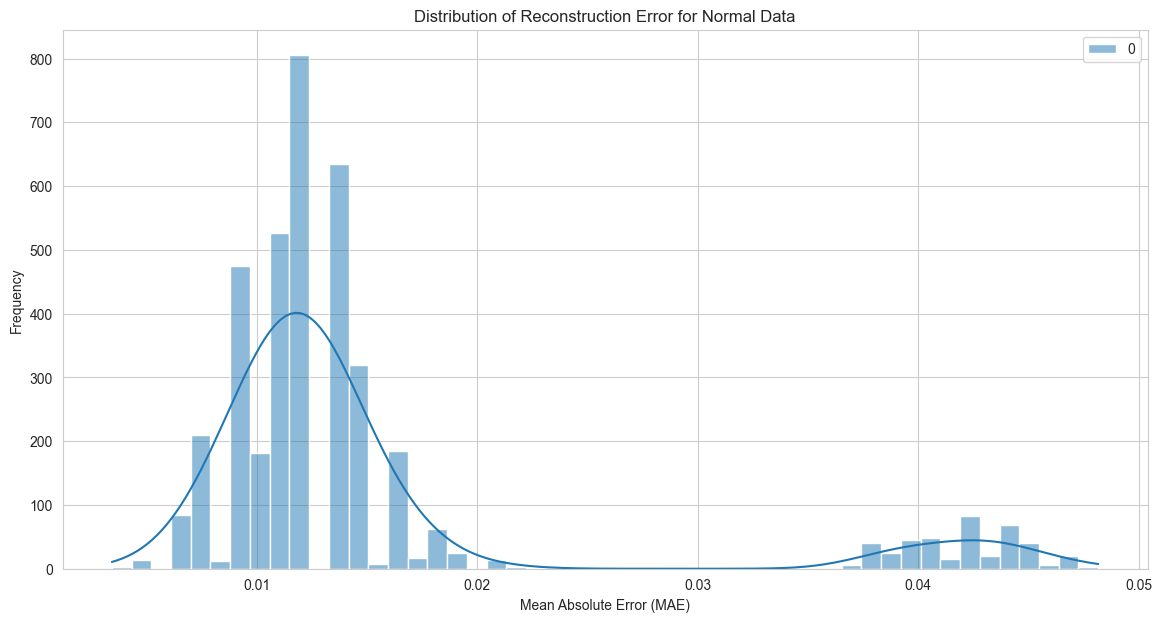

Anomaly threshold set at: 0.0454


In [8]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.figure(figsize=(14, 7))
sns.histplot(train_mae_loss, bins=50, kde=True)
plt.title('Distribution of Reconstruction Error for Normal Data')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Set the anomaly threshold at the 99th percentile of the training errors
threshold = np.percentile(train_mae_loss, 99)
print(f"Anomaly threshold set at: {threshold:.4f}")

### Classifying Anomalies on the Full Dataset
Now that we have a threshold, we will create sequences from our entire dataset (including anomalies), calculate their reconstruction error, and classify them based on whether their error is above or below the threshold.

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Anomaly classification complete.


,value,is_anomaly,value_scaled,reconstruction_error,predicted_anomaly
timestamp,,,,,
2014-02-26 22:05:00,2.344,1,1.485007,0.016229,0
2014-02-27 17:15:00,0.602,1,0.349413,0.007687,0



--- LSTM Autoencoder Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4000
           1       0.00      0.00      0.00         2

    accuracy                           0.98      4002
   macro avg       0.50      0.49      0.50      4002
weighted avg       1.00      0.98      0.99      4002


--- LSTM Autoencoder Confusion Matrix ---


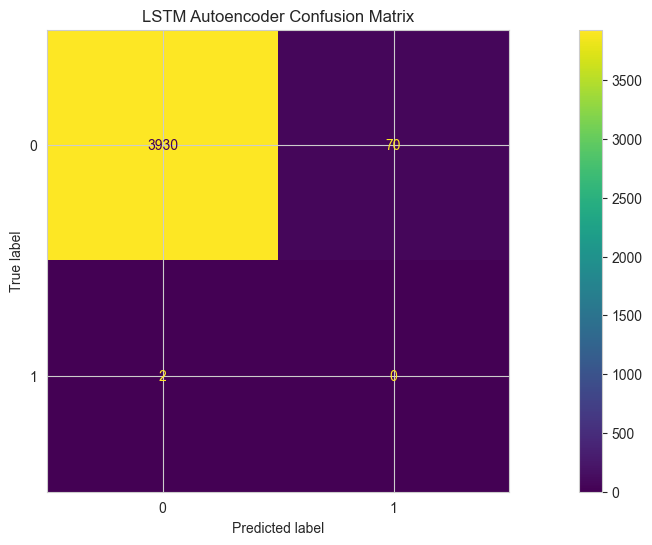

In [12]:
# Create sequences from the entire dataset
full_sequences = create_sequences(df['value_scaled'].values, TIME_STEPS)
full_sequences = np.reshape(full_sequences, (full_sequences.shape[0], full_sequences.shape[1], 1))

# Get model predictions on all data
full_mae_loss = np.mean(np.abs(model.predict(full_sequences) - full_sequences), axis=1)

# Create the final results DataFrame
# Note: The first `TIME_STEPS` data points do not have predictions
results_df = df.iloc[TIME_STEPS:].copy()
results_df['reconstruction_error'] = full_mae_loss
results_df['predicted_anomaly'] = (results_df['reconstruction_error'] > threshold).astype(int)

print("Anomaly classification complete.")
display(results_df[results_df['is_anomaly'] == 1])

# --- Final Performance Evaluation ---
print("\n--- LSTM Autoencoder Classification Report ---")
print(classification_report(results_df['is_anomaly'], results_df['predicted_anomaly']))

print("\n--- LSTM Autoencoder Confusion Matrix ---")
cm = confusion_matrix(results_df['is_anomaly'], results_df['predicted_anomaly'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('LSTM Autoencoder Confusion Matrix') 
output_path = os.path.join(RESULTS_DIR, '03_confusion_matrix_lstm.png')
plt.savefig(output_path)
plt.show()

## Model Tuning: Adjusting the Anomaly Threshold

Our initial evaluation showed that the model failed to detect any anomalies. This was because the reconstruction errors of the true anomalies were lower than our high threshold (99th percentile of normal errors).

Let's conduct an experiment by significantly lowering the threshold to see if we can improve the model's **recall**. We will try setting the threshold to the **95th percentile** and re-evaluate the performance. This should make the model more sensitive to deviations.

Old threshold (99th percentile): 0.0454
New, more sensitive threshold (95th percentile): 0.0424

--- NEW Classification Report (Threshold at 95th percentile) ---
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      4000
           1       0.00      0.00      0.00         2

    accuracy                           0.94      4002
   macro avg       0.50      0.47      0.49      4002
weighted avg       1.00      0.94      0.97      4002


--- NEW Confusion Matrix ---


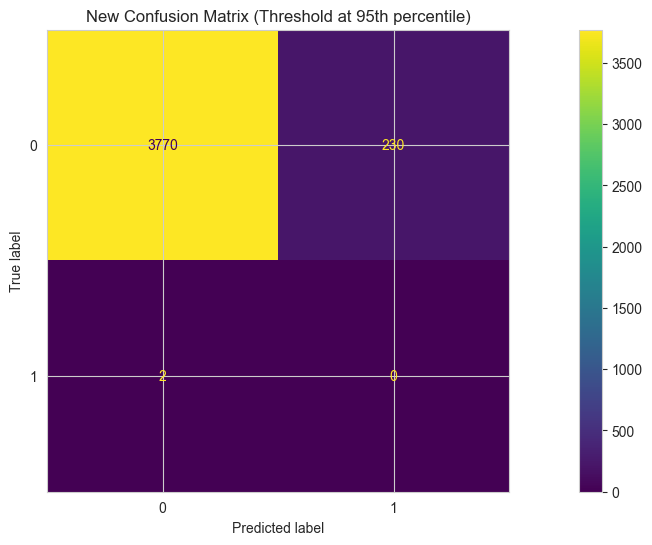

In [10]:
new_threshold = np.percentile(train_mae_loss, 95)
print(f"Old threshold (99th percentile): {threshold:.4f}")
print(f"New, more sensitive threshold (95th percentile): {new_threshold:.4f}")

results_df['predicted_anomaly_new'] = (results_df['reconstruction_error'] > new_threshold).astype(int)

print("\n--- NEW Classification Report (Threshold at 95th percentile) ---")
print(classification_report(results_df['is_anomaly'], results_df['predicted_anomaly_new']))

print("\n--- NEW Confusion Matrix ---")
cm_new = confusion_matrix(results_df['is_anomaly'], results_df['predicted_anomaly_new'])
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new)
disp_new.plot()
plt.title('New Confusion Matrix (Threshold at 95th percentile)')
plt.show()

## Final Conclusion on LSTM Autoencoder

After multiple attempts, including threshold tuning, the LSTM Autoencoder model was not able to effectively distinguish the anomalies present in this specific dataset.

The model's reconstruction error for the anomalous data points was not significantly different from the errors for normal data, resulting in a recall of 0.00. This leads to the conclusion that for this particular problem, where anomalies are characterized by sudden, extreme spikes (**point anomalies**), a simpler, statistical model like **`IsolationForest` is the more effective and efficient solution**.

This investigation highlights a critical concept in MLOps: the most complex model is not always the best. 

The final step is to save this trained model as an artifact of our experiment.

In [11]:
# Save the trained LSTM Autoencoder model
model_filename = "lstm_autoencoder_v1.h5"
model_path = os.path.join(MODELS_DIR, model_filename)

model.save(model_path)

print(f"LSTM model saved successfully as an artifact to: {model_path}")

LSTM model saved successfully as an artifact to: ..\models\lstm_autoencoder_v1.h5
